In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-science-income-prediction/sample_submission.csv
/kaggle/input/data-science-income-prediction/train.csv
/kaggle/input/data-science-income-prediction/test.csv
/kaggle/input/data-science-income-prediction/column_desctiptions.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.impute import SimpleImputer
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_df = pd.read_csv('/kaggle/input/data-science-income-prediction/train.csv')
test_df = pd.read_csv('/kaggle/input/data-science-income-prediction/test.csv')
test_ids = test_df['id']

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

In [ ]:
missing_values = train_df.isnull().sum()
missing_percentage = (missing_values / len(train_df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 
                           'Missing Percentage': missing_percentage})
print("\nMissing values in training data:")
print(missing_df.sort_values('Missing Percentage', ascending=False))

columns_to_drop = [
    'address_role', 'zip_code', 'deposit_balance', 'deposit_incoming',
    'deposit_outgoing', 'credit_history_3_years', 'credit_history_1_year', 
    'housing_type', 'marital_status', 'children', 'average_loan_24_months',
    'employment_time', 'average_outstanding_balance_6_months', 'employment_industry',
    'family_status', 'max_outstanding_balance_12_months'
]

train_df.drop(columns=columns_to_drop, inplace=True)
test_df.drop(columns=[col for col in columns_to_drop if col in test_df.columns], inplace=True)

print("\nRemaining columns after dropping high-missing columns:")
print(train_df.columns.tolist())

In [ ]:
label_encoder = LabelEncoder()
for col in ['gender', 'income_type', 'education']:
    if col in train_df.columns:
        train_df[col] = label_encoder.fit_transform(train_df[col].astype(str))
        test_df[col] = label_encoder.transform(test_df[col].astype(str))

current_year = 2025
train_df['age'] = current_year - pd.to_datetime(train_df['date_of_birth']).dt.year
test_df['age'] = current_year - pd.to_datetime(test_df['date_of_birth']).dt.year

train_df.drop(columns=['date_of_birth'], inplace=True)
test_df.drop(columns=['date_of_birth'], inplace=True)

In [ ]:
if 'total_debt' in train_df.columns and train_df['total_debt'].isnull().sum() > 0:
    imputer = SimpleImputer(strategy='mean')
    train_df['total_debt'] = imputer.fit_transform(train_df[['total_debt']])
    if 'total_debt' in test_df.columns:
        test_df['total_debt'] = imputer.transform(test_df[['total_debt']])

In [ ]:
train_df['age_squared'] = train_df['age'] ** 2
test_df['age_squared'] = test_df['age'] ** 2

train_df['age_log'] = np.log1p(train_df['age'])
test_df['age_log'] = np.log1p(test_df['age'])

train_df['age_group'] = pd.cut(train_df['age'], 
                               bins=[0, 25, 35, 45, 55, 65, np.inf], 
                               labels=[0, 1, 2, 3, 4, 5])
test_df['age_group'] = pd.cut(test_df['age'], 
                              bins=[0, 25, 35, 45, 55, 65, np.inf], 
                              labels=[0, 1, 2, 3, 4, 5])

train_df['age_group'] = train_df['age_group'].astype(int)
test_df['age_group'] = test_df['age_group'].astype(int)

train_df['gender_income_interaction'] = train_df['gender'] * train_df['income_type']
test_df['gender_income_interaction'] = test_df['gender'] * test_df['income_type']

train_df['age_education_interaction'] = train_df['age'] * train_df['education']
test_df['age_education_interaction'] = test_df['age'] * test_df['education']

train_df['age_gender_interaction'] = train_df['age'] * train_df['gender']
test_df['age_gender_interaction'] = test_df['age'] * test_df['gender']

In [ ]:
train_df = pd.get_dummies(train_df, columns=['income_type', 'education'], drop_first=False)
test_df = pd.get_dummies(test_df, columns=['income_type', 'education'], drop_first=False)

scaler = StandardScaler()
numeric_cols = ['age', 'age_squared', 'age_log', 'total_debt']
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

In [ ]:
train_cols = set(train_df.columns)
test_cols = set(test_df.columns)

for col in train_cols - test_cols:
    if col != 'primary_income':  
        test_df[col] = 0

for col in test_cols - train_cols:
    train_df[col] = 0

print("\nChecking column consistency:")
common_cols = sorted(list(set(train_df.columns) & set(test_df.columns)))
common_cols = [col for col in common_cols if col != 'primary_income' and col != 'id']
print(f"Number of common features: {len(common_cols)}")


In [ ]:
X = train_df.drop(columns=['primary_income', 'id'])
y = train_df['primary_income']

y_log = np.log1p(y)

X_train, X_val, y_train, y_val = train_test_split(X, y_log, test_size=0.2, random_state=42)


In [ ]:
print("\nTraining XGBoost model with hyperparameter tuning...")
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_percentage_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_

y_val_pred = best_model.predict(X_val)
y_val_pred_original = np.expm1(y_val_pred)
y_val_original = np.expm1(y_val)

mape = mean_absolute_percentage_error(y_val_original, y_val_pred_original)
rmse = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))
print(f"\nValidation MAPE: {mape:.4f}")
print(f"Validation RMSE: {rmse:.2f}")


Training data shape: (1300000, 23)
Testing data shape: (226659, 22)

Missing values in training data:
                                      Missing Values  Missing Percentage
children                                     1300000          100.000000
marital_status                               1299999           99.999923
address_role                                 1289538           99.195231
credit_history_3_years                       1268855           97.604231
credit_history_1_year                        1268855           97.604231
deposit_incoming                             1256488           96.652923
deposit_balance                              1256488           96.652923
deposit_outgoing                             1256488           96.652923
housing_type                                 1214186           93.398923
average_loan_24_months                       1161759           89.366077
employment_industry                           855176           65.782769
employment_time       

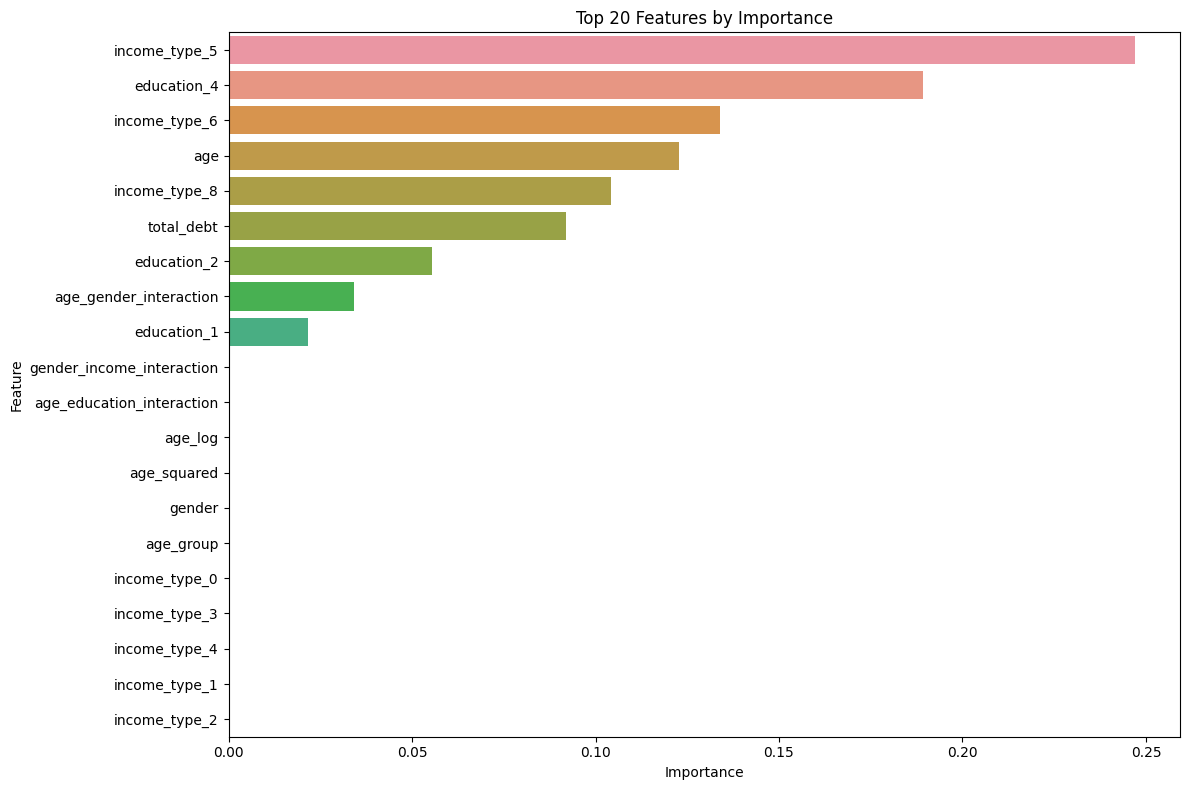

In [1]:
print("\nTraining LightGBM model...")
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)
lgb_model.fit(X_train, y_train)

print("\nTraining Random Forest model...")
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

print("\nCreating ensemble model...")
ensemble = VotingRegressor(
    estimators=[
        ('xgb', best_model),
        ('lgb', lgb_model),
        ('rf', rf_model)
    ]
)
ensemble.fit(X_train, y_train)

y_val_pred_ensemble = ensemble.predict(X_val)
y_val_pred_ensemble_original = np.expm1(y_val_pred_ensemble)

mape_ensemble = mean_absolute_percentage_error(y_val_original, y_val_pred_ensemble_original)
print(f"Ensemble Validation MAPE: {mape_ensemble:.4f}")

if mape_ensemble < mape:
    print("Using Ensemble model for final predictions")
    final_model = ensemble
else:
    print("Using XGBoost model for final predictions")
    final_model = best_model

final_model.fit(X, y_log)

X_test = test_df.drop(columns=['id'])

missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0

X_test = X_test[X.columns]

test_predictions_log = final_model.predict(X_test)
test_predictions = np.expm1(test_predictions_log)

submission = pd.DataFrame({'id': test_ids, 'primary_income': test_predictions})
submission.to_csv('submission_improved.csv', index=False)

print("\nSubmission file created: submission_improved.csv")